In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import wandb
from nnfabrik.builder import get_data

import csng
from csng.InvertedEncoder import InvertedEncoder
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, plot_losses
from csng.losses import SSIMLoss, MSELossWithCrop, Loss, MS_SSIMLoss, PerceptualLoss
from csng.data import MixedBatchLoader
from csng.readins import (
    MultiReadIn,
    HypernetReadIn,
    ConvReadIn,
    AttentionReadIn,
    FCReadIn,
    AutoEncoderReadIn,
    Conv1dReadIn,
)

from BoostedInvertedEncoder import BoostedInvertedEncoder
from encoder import get_encoder
from data_utils import get_mouse_v1_data, PerSampleStoredDataset, append_syn_dataloaders

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

%env "WANDB_NOTEBOOK_NAME" "cnn_decoder.ipynb"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'
env: "WANDB_NOTEBOOK_NAME"="cnn_decoder.ipynb"


wandb: Currently logged in as: johnny1188. Use `wandb login --relogin` to force relogin


True

In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    "crop_win": (22, 36),
    "wandb": None,
}
print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()
config["data"]["mouse_v1"] = None
config["data"]["syn_dataset_config"] = None
config["data"]["data_augmentation"] = None

### Mouse V1 dataset (Sensorium 2022)

In [8]:
### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    # "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    # "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    # "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    # "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"]["mouse_v1"] = {
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 16,
        # "batch_size": 7,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 100,
    "device": config["device"],
}

In [9]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config["data"])

Training dataset:	 4480 samples
Validation dataset:	 528 samples
Test dataset:		 16 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([100, 1, 36, 64])
  min=-1.750  max=2.261
  mean=0.118  std=0.954
responses:
  torch.Size([100, 8372])
  min=0.000  max=21.902
  mean=0.297  std=0.527
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


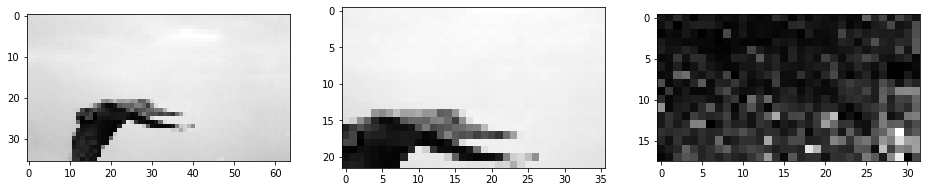

In [10]:
### show data
sample_data_key = dataloaders["mouse_v1"]["test"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

### Synthetic dataset (different image stimuli -> encoder -> responses)

In [ ]:
### append synthetic data
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        # "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 3,
    "append_data_parts": ["train"],
    "data_key_prefix": "syn",
}

dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

In [ ]:
### show data
syn_stim, syn_resp, syn_pupil_center = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[-1]))
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {syn_stim.shape}"
    f"\n  min={syn_stim.min().item():.3f}  max={syn_stim.max().item():.3f}"
    f"\n  mean={syn_stim.mean().item():.3f}  std={syn_stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {syn_resp.shape}"
    f"\n  min={syn_resp.min().item():.3f}  max={syn_resp.max().item():.3f}"
    f"\n  mean={syn_resp.mean().item():.3f}  std={syn_resp.std().item():.3f}"
    "\nNeuron coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
    "\nPupil center:"
    f"\n  {syn_pupil_center.shape}"
    f"\n  min={syn_pupil_center.min().item():.3f}  max={syn_pupil_center.max().item():.3f}"
    f"\n  mean={syn_pupil_center.mean().item():.3f}  std={syn_pupil_center.std().item():.3f}"
)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.imshow(syn_stim[0].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(122)
reshape_to = None
for i in range(30, 150):
    if syn_resp.shape[-1] % i == 0:
        reshape_to = (i, syn_resp.shape[-1] // i)
        break
if reshape_to != None:
    ax.imshow(syn_resp[0].view(reshape_to).squeeze(0).unsqueeze(-1).cpu(), cmap="gray")

plt.show()

## Encoder

In [ ]:
encoder = get_encoder(ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22.pth"), device=config["device"], eval_mode=True)

In [ ]:
### load encoder
print("Loading encoder...")

from lurz2020.models.models import se2d_fullgaussian2d

### load pretrained encoder ckpt
encoder_ckpt = torch.load(
    os.path.join(DATA_PATH, "models", "encoder.pt"),
    map_location=config["device"],
    pickle_module=dill,
)

### get temporary dataloaders for the encoder
_dataloaders = get_data(
    encoder_ckpt["config"]["data"]["dataset_fn"],
    encoder_ckpt["config"]["data"]["dataset_config"]
)

### init encoder
encoder = se2d_fullgaussian2d(
    **encoder_ckpt["config"]["encoder"]["model_config"],
    dataloaders=_dataloaders,
    seed=encoder_ckpt["config"]["seed"],
).float()
encoder.load_state_dict(encoder_ckpt["encoder_state"], strict=True)
encoder.to(config["device"])
encoder.eval()
del _dataloaders

## Analysis

In [11]:
### load model
ckpt_path = os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_15-10-47", "decoder.pt")
ckpt = torch.load(ckpt_path, map_location=config["device"], pickle_module=dill)
ckpt_config = ckpt["config"]

decoder = MultiReadIn(**ckpt_config["decoder"]["model"]).to(config["device"])
decoder.load_state_dict(ckpt["best"]["model"])
decoder.eval()

[WARNING] resp_shape in core_config will be overwritten by the output of the last readin layer (shape 144)


MultiReadIn(
  (readins): ModuleDict(
    (21067-10-18): ModuleList(
      (0): ConvReadIn(
        (shifter_net): ShifterNet(
          (layers): Sequential(
            (0): Linear(in_features=2, out_features=10, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=10, out_features=10, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Linear(in_features=10, out_features=2, bias=True)
            (5): Tanh()
          )
        )
        (pointwise_conv): Sequential(
          (0): Identity()
          (1): Conv2d(8372, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.01)
        )
        (grid_net): Sequential(
          (0): Linear(in_features=4, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Dropout(p=0.1, inplace=False)
          (3)

In [ ]:
### attach a hook to a particular part of decoder and track its output
# out = []
# def hook(module, input, output):
#     out.append(output)
# decoder.readins[sample_data_key][0].grid_net.register_forward_hook(hook)

In [12]:
with torch.no_grad():
    stim_pred = decoder(
        resp.to(config["device"]),
        data_key=sample_data_key,
        neuron_coords=neuron_coords[sample_data_key].to(config["device"]),
        pupil_center=pupil_center.to(config["device"]),
    )

In [13]:
neuron_maps = decoder.readins[sample_data_key][0].pos_x  # (B, N_neurons, H, W)

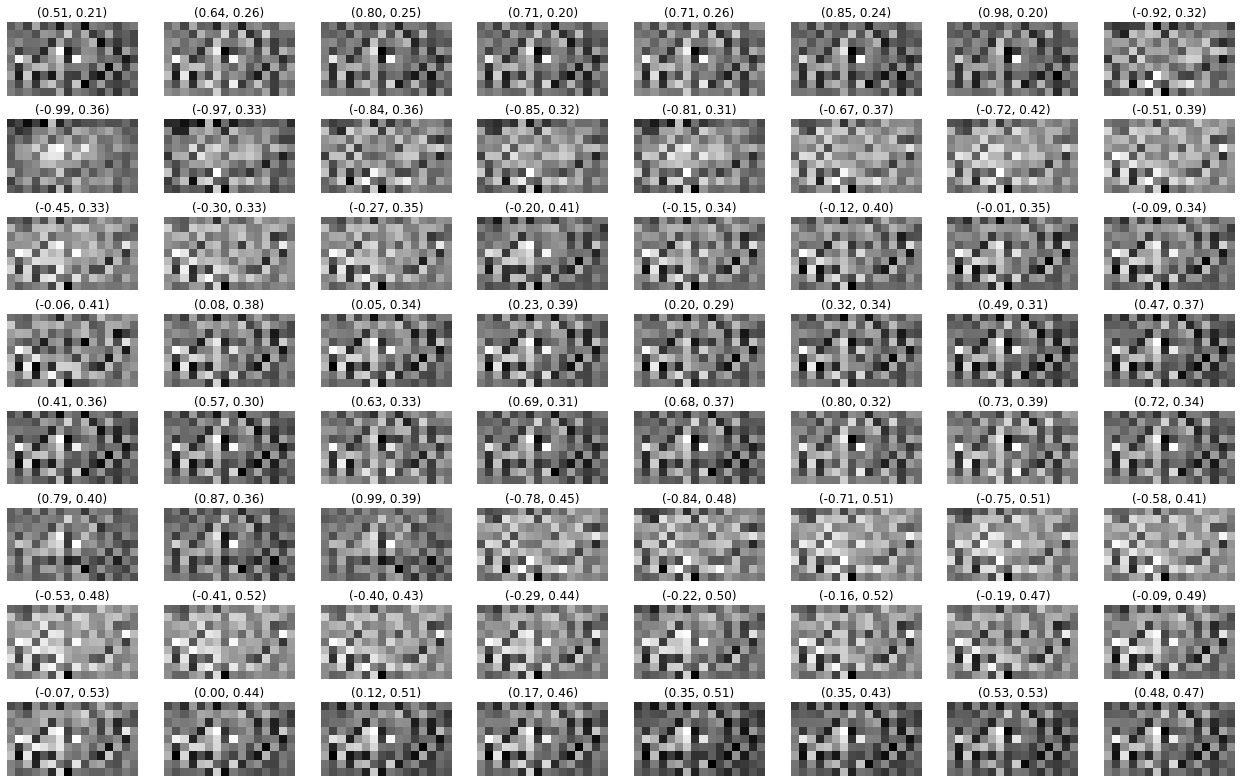

In [19]:
### plot maps of first 64 neurons
fig = plt.figure(figsize=(22, 14))
axes = fig.subplots(8, 8).flatten()
s = 300
for i in range(s, s + 64):
    # to_plot = standardize(neuron_maps.mean(0)[i], dim=(0,1))
    to_plot = neuron_maps.mean(0)[i]
    axes[i - s].imshow(to_plot.detach().cpu(), cmap="gray")
    axes[i - s].set_title(
        f"({neuron_coords[sample_data_key][i,0].item():.2f}, {neuron_coords[sample_data_key][i,1].item():.2f})"
    )
    axes[i - s].axis("off")
plt.show()

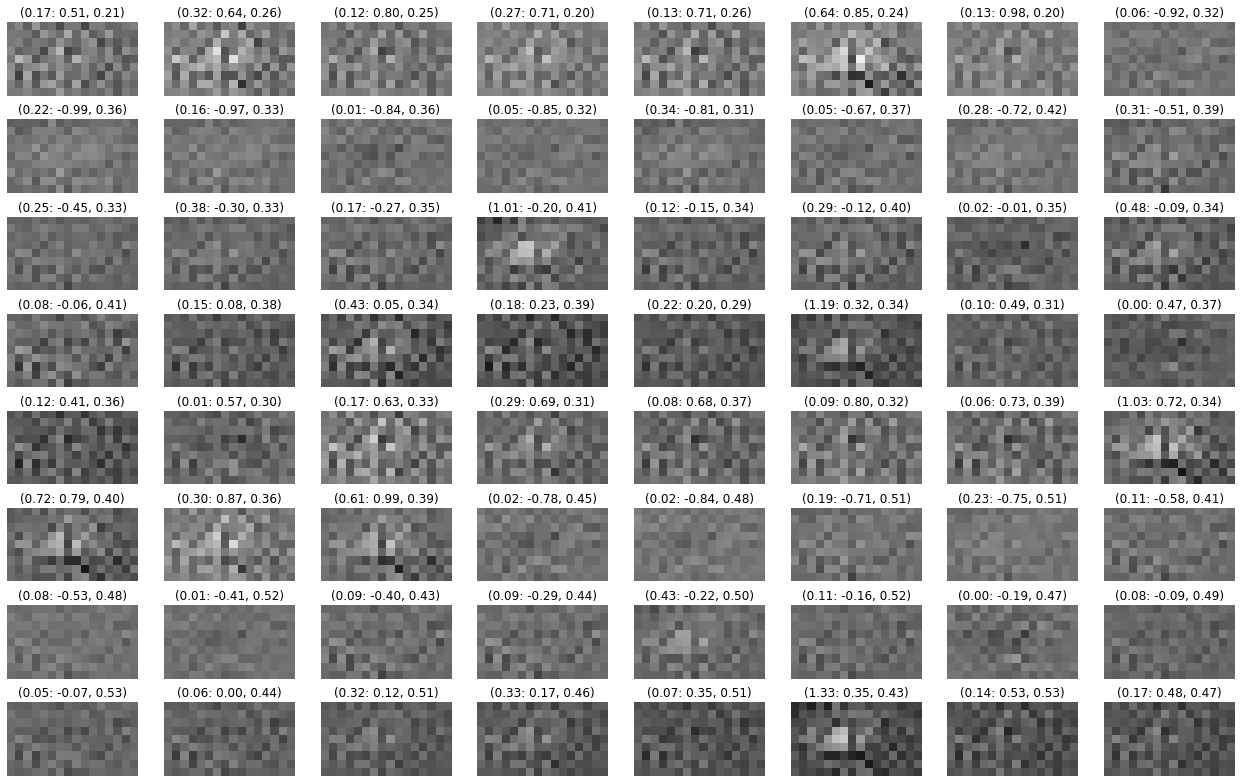

In [20]:
### plot maps of first 64 neurons on sample_idx
sample_idx = 0
fig = plt.figure(figsize=(22, 14))
axes = fig.subplots(8, 8).flatten()
s = 300
for i in range(s, s + 64):
    to_plot = neuron_maps[sample_idx,i]
    axes[i - s].imshow(to_plot.detach().cpu(), cmap="gray",
                   vmin=neuron_maps[:,i].min().item(), vmax=neuron_maps[:,i].max().item())
    axes[i - s].set_title(
        f"({resp[sample_idx,i].item():.2f}: {neuron_coords[sample_data_key][i,0].item():.2f}, {neuron_coords[sample_data_key][i,1].item():.2f})"
    )
    axes[i - s].axis("off")
plt.show()